In [1]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pandas as pd
import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import preprocessing
from keras.utils import np_utils
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv("../data/titanic/train.csv")
test = pd.read_csv("../data/titanic/test.csv")
train = train.append(test) ## test 데이터도 학습에 이용.

# inplace=True 로 해야 모든 컬럼에 대해 fillna 가 이뤄짐.
# train.fillna(0, inplace=True) 
# test.fillna(0, inplace=True)


print(train.shape)
print(test.shape)

train



Using TensorFlow backend.


(1309, 12)
(418, 11)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


In [2]:

# cols = PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked

# 데이터 전처리 : 학습에 필요없는 column 제거.
train.pop('Name'), test.pop('Name')
train.pop('Ticket'), test.pop('Ticket')
train.pop('Cabin'), test.pop('Cabin')
train.pop('PassengerId'), test.pop('PassengerId') # 제거하지 않으면 passengerId 가 높을수록 predicton value 가 높은 현상

# train 은 Nan data 제거하고, test 는 row 수를 유지하기 위해 drop 대신 fill.
train.dropna(inplace=True)
test.fillna(0, inplace=True)
print(train.shape)
print(test.shape)

# 데이터 전처리 : One Hot Encoding
# 성별, 승선지 는 String data. -> labelBinarizer를 이용해서 자동으로 one-hot-encoding
# 컬럼의 data 종류 학습.
# one-hot-encode 형태의 컬럼 추가.
# 구 컬럼 삭제 ( DataFrame.pop() )
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
enc = encoder.fit(train[['Embarked']].astype(str))
train = pd.merge(train, pd.DataFrame(enc.transform(train[['Embarked']].astype(str))) , right_index=True, left_index=True)
test = pd.merge(test, pd.DataFrame(enc.transform(test[['Embarked']].astype(str))) , right_index=True, left_index=True)
enc = encoder.fit(train[['Sex']].astype(str))
train = pd.merge(train, pd.DataFrame(enc.transform(train[['Sex']].astype(str))) , right_index=True, left_index=True)
test = pd.merge(test, pd.DataFrame(enc.transform(test[['Sex']].astype(str))) , right_index=True, left_index=True)
train.pop('Embarked'), test.pop('Embarked')
train.pop('Sex'), test.pop('Sex')

# label
y_train = train[['Survived']]

# feature
train.pop('Survived')
x_train = train
x_test = test

x_train.head(5)



(712, 8)
(418, 7)


,Age,Fare,Parch,Pclass,SibSp,0_x,1,2,0_y
0,22.0,7.2500,0,3,1,0,0,1,1
1,38.0,71.2833,0,1,1,1,0,0,0
2,26.0,7.9250,0,3,0,0,0,1,0
3,35.0,53.1000,0,1,1,0,0,1,0
4,35.0,8.0500,0,3,0,0,0,1,1


In [3]:
# #### outlier detection #####
# from sklearn.cluster import DBSCAN
# outlier_detection = DBSCAN(
#     eps = 50,
#     metric="euclidean",
#     n_jobs = -1)
# clusters = outlier_detection.fit_predict(train[['Fare']])
# clusters

In [4]:
# mixmax scaler, normalizer 등의 전처리 아직 없음.

(array([ 264.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  182.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

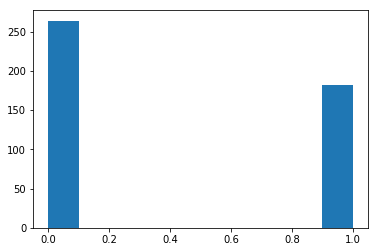

In [5]:
# 대강의 label 분포 보기
plt.hist(y_train['Survived'])

In [6]:
x_test.head(5)

,Pclass,Age,SibSp,Parch,Fare,0_x,1,2,0_y
0,3,34.5,0,0,7.8292,0,1,0,1
1,3,47.0,1,0,7.0000,0,0,1,0
2,2,62.0,0,0,9.6875,0,1,0,1
3,3,27.0,0,0,8.6625,0,0,1,1
4,3,22.0,1,1,12.2875,0,0,1,0


In [57]:

model = Sequential()
model.add(Dense(50, activation='relu', input_dim=len(x_train.columns)))
# model.add(Dropout(0.1)) # 과적합방지 Dropout. 
model.add(Dense(20, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# opt = optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
opt = optimizers.Adam(lr=0.0001, amsgrad=True)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

print(model.summary)

hist = model.fit(x_train, y_train, epochs=500, batch_size=5,validation_split=0.1)

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x1a2d2e0588>>
Train on 401 samples, validate on 45 samples
Epoch 1/500
401/401 [==============================] - 1s 3ms/step - loss: 2.3818 - acc: 0.3416 - val_loss: 1.7385 - val_acc: 0.3556
Epoch 2/500
401/401 [==============================] - 0s 371us/step - loss: 1.3941 - acc: 0.3491 - val_loss: 1.0979 - val_acc: 0.2444
Epoch 3/500
401/401 [==============================] - 0s 369us/step - loss: 0.8780 - acc: 0.4214 - val_loss: 0.9276 - val_acc: 0.3556
Epoch 4/500
401/401 [==============================] - 0s 349us/step - loss: 0.7616 - acc: 0.5810 - val_loss: 0.8473 - val_acc: 0.5111
Epoch 5/500
401/401 [==============================] - 0s 364us/step - loss: 0.7339 - acc: 0.5810 - val_loss: 0.8790 - val_acc: 0.4444
Epoch 6/500
401/401 [==============================] - 0s 360us/step - loss: 0.6989 - acc: 0.6035 - val_loss: 0.7853 - val_acc: 0.5111
Epoch 7/500
401/401 [==============================] 

401/401 [==============================] - 0s 386us/step - loss: 0.6093 - acc: 0.6683 - val_loss: 0.7121 - val_acc: 0.6000
Epoch 61/500
401/401 [==============================] - 0s 350us/step - loss: 0.6156 - acc: 0.6633 - val_loss: 0.6703 - val_acc: 0.6222
Epoch 62/500
401/401 [==============================] - 0s 357us/step - loss: 0.6137 - acc: 0.6708 - val_loss: 0.7125 - val_acc: 0.6000
Epoch 63/500
401/401 [==============================] - 0s 335us/step - loss: 0.6112 - acc: 0.6733 - val_loss: 0.6835 - val_acc: 0.6000
Epoch 64/500
401/401 [==============================] - 0s 343us/step - loss: 0.6120 - acc: 0.6608 - val_loss: 0.6599 - val_acc: 0.6444
Epoch 65/500
401/401 [==============================] - 0s 349us/step - loss: 0.6155 - acc: 0.6708 - val_loss: 0.6927 - val_acc: 0.6000
Epoch 66/500
401/401 [==============================] - 0s 332us/step - loss: 0.6120 - acc: 0.6683 - val_loss: 0.6849 - val_acc: 0.6000
Epoch 67/500
401/401 [==============================] - 0s 34

401/401 [==============================] - 0s 366us/step - loss: 0.5978 - acc: 0.7032 - val_loss: 0.6871 - val_acc: 0.6222
Epoch 121/500
401/401 [==============================] - 0s 338us/step - loss: 0.5949 - acc: 0.7007 - val_loss: 0.6956 - val_acc: 0.6000
Epoch 122/500
401/401 [==============================] - 0s 351us/step - loss: 0.5950 - acc: 0.7032 - val_loss: 0.6988 - val_acc: 0.6222
Epoch 123/500
401/401 [==============================] - 0s 349us/step - loss: 0.5925 - acc: 0.6933 - val_loss: 0.6450 - val_acc: 0.6889
Epoch 124/500
401/401 [==============================] - 0s 341us/step - loss: 0.6116 - acc: 0.7007 - val_loss: 0.6642 - val_acc: 0.6667
Epoch 125/500
401/401 [==============================] - 0s 347us/step - loss: 0.5953 - acc: 0.6908 - val_loss: 0.6651 - val_acc: 0.6667
Epoch 126/500
401/401 [==============================] - 0s 346us/step - loss: 0.5920 - acc: 0.6958 - val_loss: 0.6577 - val_acc: 0.6889
Epoch 127/500
401/401 [==============================] 

Epoch 180/500
401/401 [==============================] - 0s 365us/step - loss: 0.5867 - acc: 0.7057 - val_loss: 0.6654 - val_acc: 0.6889
Epoch 181/500
401/401 [==============================] - 0s 341us/step - loss: 0.5845 - acc: 0.7057 - val_loss: 0.6628 - val_acc: 0.6889
Epoch 182/500
401/401 [==============================] - 0s 354us/step - loss: 0.5822 - acc: 0.7082 - val_loss: 0.6787 - val_acc: 0.7111
Epoch 183/500
401/401 [==============================] - 0s 349us/step - loss: 0.5935 - acc: 0.7007 - val_loss: 0.6536 - val_acc: 0.6889
Epoch 184/500
401/401 [==============================] - 0s 327us/step - loss: 0.5832 - acc: 0.7132 - val_loss: 0.6554 - val_acc: 0.6889
Epoch 185/500
401/401 [==============================] - 0s 330us/step - loss: 0.5805 - acc: 0.7207 - val_loss: 0.7052 - val_acc: 0.6000
Epoch 186/500
401/401 [==============================] - 0s 334us/step - loss: 0.5785 - acc: 0.7082 - val_loss: 0.6400 - val_acc: 0.6889
Epoch 187/500
401/401 [==================

Epoch 240/500
401/401 [==============================] - 0s 357us/step - loss: 0.5784 - acc: 0.7232 - val_loss: 0.6430 - val_acc: 0.6889
Epoch 241/500
401/401 [==============================] - 0s 337us/step - loss: 0.5801 - acc: 0.7157 - val_loss: 0.6366 - val_acc: 0.6667
Epoch 242/500
401/401 [==============================] - 0s 345us/step - loss: 0.5745 - acc: 0.7107 - val_loss: 0.6822 - val_acc: 0.6889
Epoch 243/500
401/401 [==============================] - 0s 339us/step - loss: 0.5804 - acc: 0.7157 - val_loss: 0.6962 - val_acc: 0.6444
Epoch 244/500
401/401 [==============================] - 0s 349us/step - loss: 0.5775 - acc: 0.7132 - val_loss: 0.6405 - val_acc: 0.6667
Epoch 245/500
401/401 [==============================] - 0s 348us/step - loss: 0.5741 - acc: 0.7157 - val_loss: 0.6331 - val_acc: 0.6889
Epoch 246/500
401/401 [==============================] - 0s 341us/step - loss: 0.5759 - acc: 0.7207 - val_loss: 0.6817 - val_acc: 0.7111
Epoch 247/500
401/401 [==================

Epoch 300/500
401/401 [==============================] - 0s 353us/step - loss: 0.5725 - acc: 0.7107 - val_loss: 0.6429 - val_acc: 0.6667
Epoch 301/500
401/401 [==============================] - 0s 338us/step - loss: 0.5726 - acc: 0.7232 - val_loss: 0.6613 - val_acc: 0.6889
Epoch 302/500
401/401 [==============================] - 0s 343us/step - loss: 0.5711 - acc: 0.7207 - val_loss: 0.7027 - val_acc: 0.6444
Epoch 303/500
401/401 [==============================] - 0s 342us/step - loss: 0.5742 - acc: 0.7157 - val_loss: 0.6637 - val_acc: 0.6889
Epoch 304/500
401/401 [==============================] - 0s 344us/step - loss: 0.5764 - acc: 0.7132 - val_loss: 0.6606 - val_acc: 0.6889
Epoch 305/500
401/401 [==============================] - 0s 346us/step - loss: 0.5741 - acc: 0.7107 - val_loss: 0.6418 - val_acc: 0.6667
Epoch 306/500
401/401 [==============================] - 0s 341us/step - loss: 0.5722 - acc: 0.7232 - val_loss: 0.6488 - val_acc: 0.6889
Epoch 307/500
401/401 [==================

Epoch 360/500
401/401 [==============================] - 0s 348us/step - loss: 0.5740 - acc: 0.7132 - val_loss: 0.6408 - val_acc: 0.6667
Epoch 361/500
401/401 [==============================] - 0s 338us/step - loss: 0.5683 - acc: 0.7282 - val_loss: 0.6893 - val_acc: 0.7111
Epoch 362/500
401/401 [==============================] - 0s 350us/step - loss: 0.5722 - acc: 0.7082 - val_loss: 0.6802 - val_acc: 0.7111
Epoch 363/500
401/401 [==============================] - 0s 340us/step - loss: 0.5688 - acc: 0.7257 - val_loss: 0.6575 - val_acc: 0.6889
Epoch 364/500
401/401 [==============================] - 0s 345us/step - loss: 0.5696 - acc: 0.7232 - val_loss: 0.6473 - val_acc: 0.6889
Epoch 365/500
401/401 [==============================] - 0s 344us/step - loss: 0.5794 - acc: 0.7057 - val_loss: 0.6657 - val_acc: 0.6889
Epoch 366/500
401/401 [==============================] - 0s 342us/step - loss: 0.5649 - acc: 0.7282 - val_loss: 0.6530 - val_acc: 0.6889
Epoch 367/500
401/401 [==================

Epoch 420/500
401/401 [==============================] - 0s 367us/step - loss: 0.5658 - acc: 0.7207 - val_loss: 0.6544 - val_acc: 0.6667
Epoch 421/500
401/401 [==============================] - 0s 345us/step - loss: 0.5624 - acc: 0.7257 - val_loss: 0.7036 - val_acc: 0.6222
Epoch 422/500
401/401 [==============================] - 0s 346us/step - loss: 0.5687 - acc: 0.7132 - val_loss: 0.6736 - val_acc: 0.7111
Epoch 423/500
401/401 [==============================] - 0s 341us/step - loss: 0.5639 - acc: 0.7182 - val_loss: 0.6557 - val_acc: 0.6667
Epoch 424/500
401/401 [==============================] - 0s 341us/step - loss: 0.5652 - acc: 0.7107 - val_loss: 0.6630 - val_acc: 0.6889
Epoch 425/500
401/401 [==============================] - 0s 349us/step - loss: 0.5636 - acc: 0.7282 - val_loss: 0.6337 - val_acc: 0.6667
Epoch 426/500
401/401 [==============================] - 0s 346us/step - loss: 0.5609 - acc: 0.7157 - val_loss: 0.6608 - val_acc: 0.6889
Epoch 427/500
401/401 [==================

Epoch 480/500
401/401 [==============================] - 0s 384us/step - loss: 0.5622 - acc: 0.7232 - val_loss: 0.6647 - val_acc: 0.6889
Epoch 481/500
401/401 [==============================] - 0s 343us/step - loss: 0.5585 - acc: 0.7207 - val_loss: 0.6361 - val_acc: 0.6667
Epoch 482/500
401/401 [==============================] - 0s 340us/step - loss: 0.5577 - acc: 0.7207 - val_loss: 0.6713 - val_acc: 0.6889
Epoch 483/500
401/401 [==============================] - 0s 343us/step - loss: 0.5599 - acc: 0.7307 - val_loss: 0.6769 - val_acc: 0.7111
Epoch 484/500
401/401 [==============================] - 0s 338us/step - loss: 0.5676 - acc: 0.7232 - val_loss: 0.6280 - val_acc: 0.6889
Epoch 485/500
401/401 [==============================] - 0s 340us/step - loss: 0.5628 - acc: 0.7257 - val_loss: 0.6425 - val_acc: 0.6667
Epoch 486/500
401/401 [==============================] - 0s 349us/step - loss: 0.5596 - acc: 0.7257 - val_loss: 0.6494 - val_acc: 0.6667
Epoch 487/500
401/401 [==================

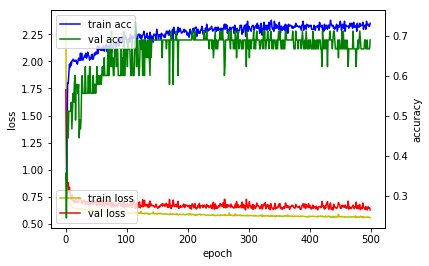

In [58]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [59]:
model.predict(x_test)

array([[  1.64850131e-02],
       [  5.45452014e-02],
       [  5.83608914e-03],
       [  1.66241582e-02],
       [  5.54132322e-03],
       [  2.42262576e-02],
       [  2.02776976e-02],
       [  7.34690411e-06],
       [  2.00038943e-02],
       [  1.16963500e-04],
       [  1.09239548e-01],
       [  1.09410548e-05],
       [  6.15577065e-16],
       [  6.55458643e-06],
       [  4.08016372e-12],
       [  7.30598867e-06],
       [  2.77455314e-03],
       [  1.81015525e-02],
       [  3.08161546e-02],
       [  8.89141858e-03],
       [  4.80460983e-12],
       [  2.76241302e-01],
       [  2.34417803e-06],
       [  2.20009688e-12],
       [  0.00000000e+00],
       [  9.36419703e-04],
       [  1.64083688e-12],
       [  1.71105377e-02],
       [  1.98883731e-06],
       [  4.10873792e-04],
       [  1.03207067e-05],
       [  4.76366722e-06],
       [  1.24208658e-04],
       [  1.23891878e-04],
       [  1.78403993e-11],
       [  1.98472608e-02],
       [  1.02994509e-01],
 

(array([ 415.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    3.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

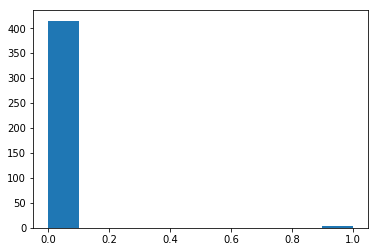

In [60]:
pred = model.predict_classes(x_test)
# live = len([x for x in pred.ravel() if x==1])
# death = len([x for x in pred.ravel() if x==0])
# print("live : " , live)
# print("death : " , death)
# print("생존율 : ", live / (live + death))
# pred

plt.hist(pred)

In [61]:
df_pred = pd.read_csv("../data/titanic/gender_submission.csv")
df_pred[['Survived']] = pred
# df_pred

In [62]:
df_pred.to_csv('result.csv', index=False)